# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk
import string

pd.set_option('mode.chained_assignment',None)

In [62]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [63]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 2]
print("Number of dialogues longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues longer than 2 turns in subreddit:  487


In [64]:
# TODO: CLEAN OUT CONVERSATIONS OF ANY LENGTH WITH ONLY A SPEAKER (e.g. conversation id 25)

In [65]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Measuring the level of engagement

In [66]:
def extract_responses(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TODO: you can only keep conversation, speaker, and listener (because others are dynamic)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [67]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TODO: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [68]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indices
                conversation.reset_index(drop=True, inplace=True)
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [69]:
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [70]:
def calculate_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    num_turns = len(conversation)
    
    engagement = ""
    
    if num_turns == 2:
        engagement = "low engagement"
        
    elif num_turns == 3:
        if is_interleaved_conversation(speaker, listener, conversation) == True and  sum_token_length > 15: # TOASK: What number to choose as token length? Is it logical to use it like this?
            engagement = "moderate engagement" 
        else:
            engagement = "low engagement"
            
    elif num_turns >= 4:
        if (is_interleaved_conversation(speaker, listener, conversation) == True or (diff <= 1)) and sum_token_length > 15: 
            engagement = "high engagement" 
        else:
            engagement = "low engagement"
            
    return round_sig(diff), engagement

## Measuring the level of satisfaction

In [71]:
def plot_emotion_sentiment(speaker_responses):   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [72]:
def calculate_satisfaction(speaker_responses, conversation, speaker):
    satisfaction = ""

    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]
    
    # If either the last speaker text is tagged with grateful & positive 
    # or if the last speaker text contains lexical details that express gratitude, add a bonus point to satisfaction.
    grateful_bonus = 0
    if check_grateful_positive(speaker_responses)==True or check_lexical_details(speaker_responses, speaker)==True:
        grateful_bonus = 0.4
        slope += grateful_bonus
        
    if len(conversation) == 2:
        satisfaction = "none"
    else:
        if slope >= 0.8: 
            satisfaction = "positive satisfaction"
        elif slope >= 0.4:
            satisfaction = "moderate satisfaction"
        elif slope < 0.4 and slope >= 0:
            satisfaction = "neutral satisfaction"
        elif slope < 0:
            satisfaction = "negative satisfaction"
            
    return round_sig(slope), satisfaction, grateful_bonus

In [73]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [74]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [75]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def check_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [76]:
def check_lexical_details(conversation, speaker):
    index = 0
    for i in range(len(conversation)-1,0,-1):
        if conversation['author'].iloc[i] == speaker:
            index = i
            break
   
    tokens = nltk.word_tokenize(conversation["text"].iloc[index])
    tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TODO: exclude quotation marks
    
    if "thank" in tokens: # if we get a lexicon of gratitude I can check if any of those words are in tokens (can also use ngrams)
        return True
        
    return False

## Final classification

In [77]:
def classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener):
    return str(calculate_engagement(speaker, listener, conversation)[1] + ", " + calculate_satisfaction(speaker_responses, conversation, speaker)[1])

## Testing the measures with examples

In [78]:
def test_examples(conversation_id):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id)
    plot_emotion_sentiment(speaker_responses)
    print("Conversation length: ", len(conversation))
    print("Speaker-listener turn difference: ", calculate_engagement(speaker, listener, conversation)[0], " --> ", calculate_engagement(speaker, listener, conversation)[1])
    print("Sentiment shift: ", calculate_satisfaction(speaker_responses, conversation, speaker)[0], " with grateful bonus: ", calculate_satisfaction(speaker_responses, conversation, speaker)[2], " --> ", calculate_satisfaction(speaker_responses, conversation, speaker)[1])
    print("Classification summary: ", classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener))
    print()

In [79]:
df[df["conversation_id"] == 24]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
55,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,1,"How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, "" we pay for that, dont we?"" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.",-0.8225,negative,anxious
56,24,MentalHealthSupport,Threatened by a stranger about mental disability.,shatterSquish,2,"That doesn't sound at all like they knew you were on disability. I think you're jumping to conclusions here. For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.",0.3400,positive,anxious
57,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,3,"Hey squish. Thanks for not just telling me it was ""all in my head.""",0.4404,positive,sentimental
58,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,4,"A. I wasnt shoplifting. And B. The phrase ""We pay for that, dont we?"" is not a normal phrase. Appreciate your input, but i disagree.",-0.4118,negative,guilty


Conversation length:  4
Speaker-listener turn difference:  1  -->  moderate engagement
Sentiment shift:  0.21  with grateful bonus:  0  -->  neutral satisfaction
Classification summary:  moderate engagement, neutral satisfaction



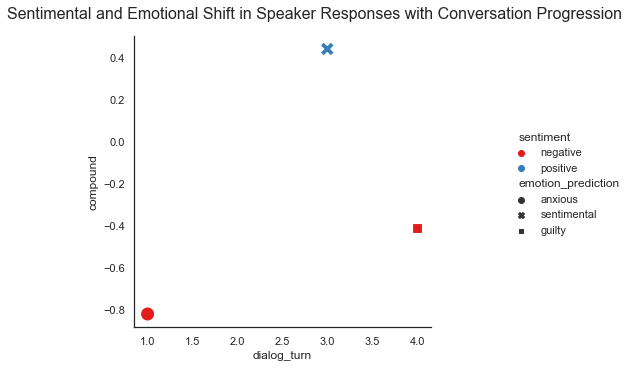

In [80]:
test_examples(24) 

### High engagement, positive satisfaction

high engagement: 854, 1003, 1732

low engagement: 77

### High engagement, negative satisfaction

### Moderate engagement, moderate satisfaction

### Low engagement, neutral satisfaction

## TODO: Improve these scoring functions

Satisfaction: 
- Take off points if speaker got offended from listener's response
- Find a lexicon of gratitude tokens

Engagement:
- Number of tokens speaker used to respond back (excluding the first turn) ++ 
- Check if the turns are interleaved (i.e. if there is interaction) ++
- Change ratio to difference ++

Examples:
- A few examples showing low/moderate/high engagement/satisfaction
